In [43]:
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import shutil 
from tqdm import tqdm
import torch
import torchvision
import warnings
warnings.filterwarnings("ignore")

## Считывание данных из архива

In [44]:
print(os.listdir('data'))

with zipfile.ZipFile('data/plates.zip', 'r') as zip_obj:
   zip_obj.extractall('/plates/')
    
print('After zip extraction:')
print(os.listdir('/plates/'))

['bio_cluster_fck.xlsx', 'creditcard.csv', 'efra2swiss.outfmt', 'plates', 'plates.zip']
After zip extraction:
['plates', '__MACOSX']


In [45]:
data_root = '/plates/plates/'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


In [46]:
train_dir = 'data/plates/train'
val_dir = 'data/plates/val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 284.44it/s]


## Нормализация изображений с помощью torchvision

In [47]:
from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),   
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(360),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [48]:
len(train_dataloader), len(train_dataset)

(5, 34)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


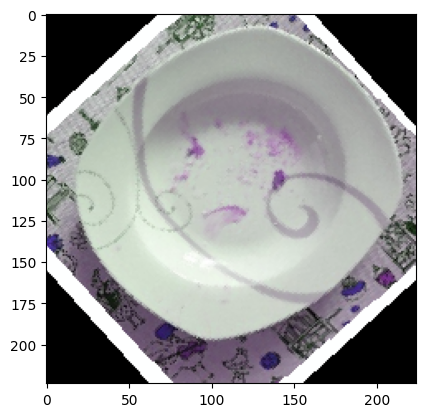

In [49]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

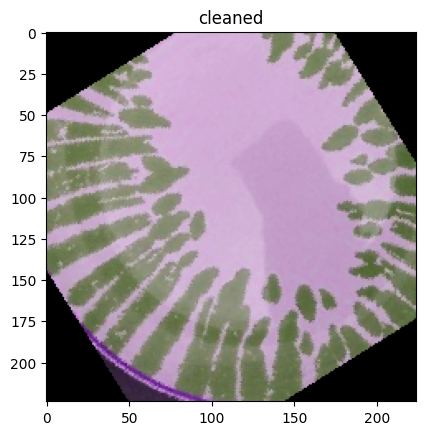

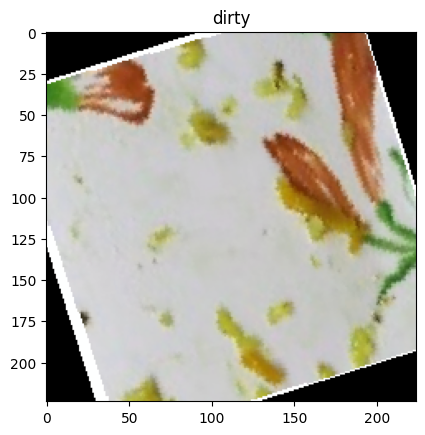

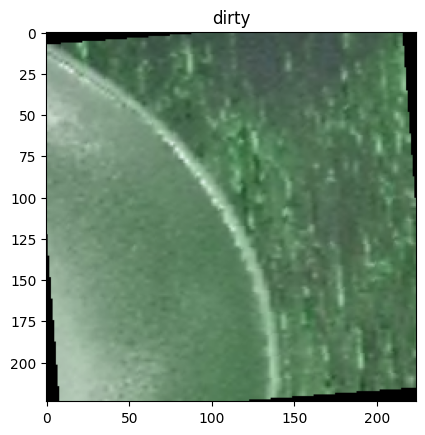

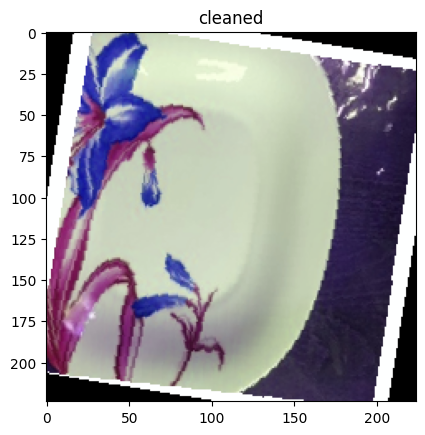

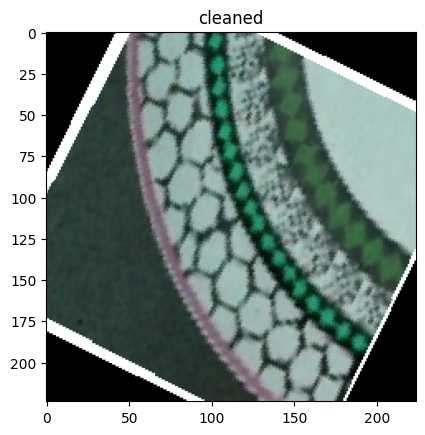

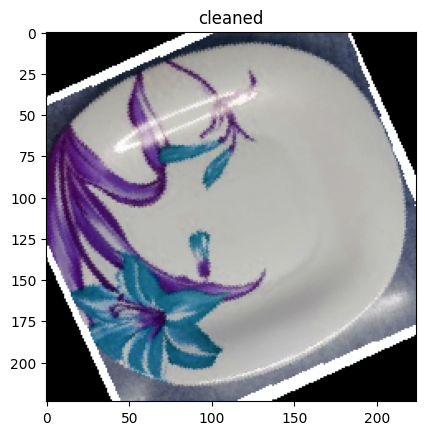

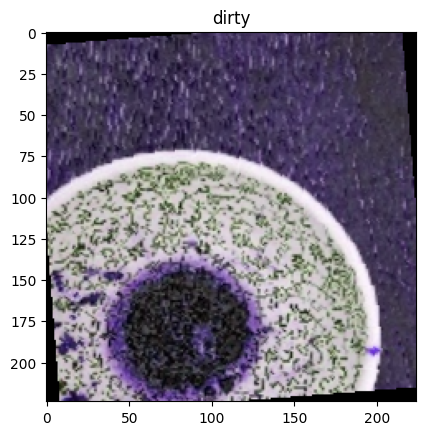

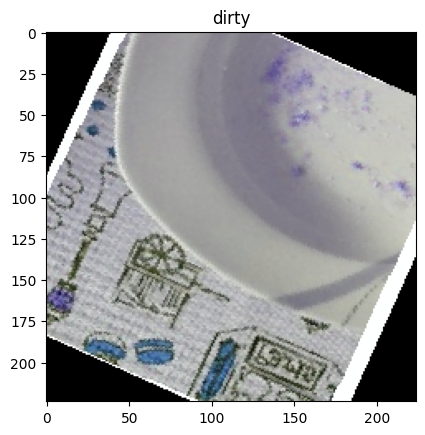

In [50]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

## Обучение модели

In [51]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            # we will print accuracy and loss stats
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [52]:
model = models.resnet152(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [53]:
train_model(model, loss, optimizer, scheduler, num_epochs=30);

Epoch 0/29:


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]

train Loss: 0.8531 Acc: 0.3500



100%|██████████| 1/1 [00:05<00:00,  5.19s/it]

val Loss: 0.6868 Acc: 0.6667
Epoch 1/29:



100%|██████████| 5/5 [00:07<00:00,  1.55s/it]

train Loss: 0.6568 Acc: 0.6250



100%|██████████| 1/1 [00:04<00:00,  4.43s/it]

val Loss: 0.7524 Acc: 0.5000
Epoch 2/29:



100%|██████████| 5/5 [00:07<00:00,  1.60s/it]

train Loss: 0.6716 Acc: 0.5250



100%|██████████| 1/1 [00:05<00:00,  5.23s/it]

val Loss: 0.5734 Acc: 0.6667
Epoch 3/29:



100%|██████████| 5/5 [00:08<00:00,  1.72s/it]

train Loss: 0.6252 Acc: 0.7000



100%|██████████| 1/1 [00:05<00:00,  5.16s/it]

val Loss: 0.5668 Acc: 0.8333
Epoch 4/29:



100%|██████████| 5/5 [00:08<00:00,  1.73s/it]

train Loss: 0.6348 Acc: 0.6250



100%|██████████| 1/1 [00:05<00:00,  5.45s/it]

val Loss: 0.6005 Acc: 0.6667
Epoch 5/29:



100%|██████████| 5/5 [00:09<00:00,  1.82s/it]

train Loss: 0.5897 Acc: 0.7000



100%|██████████| 1/1 [00:05<00:00,  5.30s/it]

val Loss: 0.6071 Acc: 0.5000
Epoch 6/29:



100%|██████████| 5/5 [00:08<00:00,  1.63s/it]

train Loss: 0.6027 Acc: 0.7000



100%|██████████| 1/1 [00:04<00:00,  4.51s/it]

val Loss: 0.6119 Acc: 0.5000
Epoch 7/29:



100%|██████████| 5/5 [00:07<00:00,  1.51s/it]

train Loss: 0.6209 Acc: 0.6000



100%|██████████| 1/1 [00:04<00:00,  4.64s/it]

val Loss: 0.6480 Acc: 0.5000
Epoch 8/29:



100%|██████████| 5/5 [00:07<00:00,  1.53s/it]

train Loss: 0.5524 Acc: 0.7500



100%|██████████| 1/1 [00:04<00:00,  4.42s/it]

val Loss: 0.6322 Acc: 0.5000
Epoch 9/29:



100%|██████████| 5/5 [00:07<00:00,  1.55s/it]

train Loss: 0.5947 Acc: 0.6250



100%|██████████| 1/1 [00:04<00:00,  4.80s/it]

val Loss: 0.6725 Acc: 0.5000
Epoch 10/29:



100%|██████████| 5/5 [00:08<00:00,  1.73s/it]

train Loss: 0.5558 Acc: 0.8500



100%|██████████| 1/1 [00:05<00:00,  5.23s/it]

val Loss: 0.5624 Acc: 0.8333
Epoch 11/29:



100%|██████████| 5/5 [00:08<00:00,  1.66s/it]

train Loss: 0.5210 Acc: 0.8250



100%|██████████| 1/1 [00:04<00:00,  4.43s/it]

val Loss: 0.6221 Acc: 0.5000
Epoch 12/29:



100%|██████████| 5/5 [00:07<00:00,  1.52s/it]

train Loss: 0.5132 Acc: 0.8000



100%|██████████| 1/1 [00:04<00:00,  4.66s/it]

val Loss: 0.6298 Acc: 0.5000
Epoch 13/29:



100%|██████████| 5/5 [00:08<00:00,  1.62s/it]

train Loss: 0.5817 Acc: 0.7500



100%|██████████| 1/1 [00:05<00:00,  5.23s/it]

val Loss: 0.6483 Acc: 0.5000
Epoch 14/29:



100%|██████████| 5/5 [00:07<00:00,  1.53s/it]

train Loss: 0.5885 Acc: 0.7750



100%|██████████| 1/1 [00:04<00:00,  4.63s/it]

val Loss: 0.6467 Acc: 0.5000
Epoch 15/29:



100%|██████████| 5/5 [00:07<00:00,  1.58s/it]

train Loss: 0.5821 Acc: 0.7000



100%|██████████| 1/1 [00:05<00:00,  5.25s/it]

val Loss: 0.6256 Acc: 0.5000
Epoch 16/29:



100%|██████████| 5/5 [00:08<00:00,  1.69s/it]

train Loss: 0.6079 Acc: 0.6750



100%|██████████| 1/1 [00:04<00:00,  4.40s/it]

val Loss: 0.6253 Acc: 0.5000
Epoch 17/29:



100%|██████████| 5/5 [00:08<00:00,  1.71s/it]

train Loss: 0.5695 Acc: 0.8000



100%|██████████| 1/1 [00:05<00:00,  5.40s/it]

val Loss: 0.6593 Acc: 0.5000
Epoch 18/29:



100%|██████████| 5/5 [00:08<00:00,  1.65s/it]

train Loss: 0.5138 Acc: 0.8500



100%|██████████| 1/1 [00:04<00:00,  4.38s/it]

val Loss: 0.6552 Acc: 0.5000
Epoch 19/29:



100%|██████████| 5/5 [00:07<00:00,  1.54s/it]

train Loss: 0.5431 Acc: 0.7500



100%|██████████| 1/1 [00:04<00:00,  4.49s/it]

val Loss: 0.6484 Acc: 0.5000
Epoch 20/29:



100%|██████████| 5/5 [00:07<00:00,  1.54s/it]

train Loss: 0.5475 Acc: 0.8500



100%|██████████| 1/1 [00:04<00:00,  4.59s/it]

val Loss: 0.6323 Acc: 0.5000
Epoch 21/29:



100%|██████████| 5/5 [00:07<00:00,  1.56s/it]

train Loss: 0.6003 Acc: 0.6500



100%|██████████| 1/1 [00:04<00:00,  4.32s/it]

val Loss: 0.6095 Acc: 0.5000
Epoch 22/29:



100%|██████████| 5/5 [00:07<00:00,  1.54s/it]

train Loss: 0.5081 Acc: 0.8500



100%|██████████| 1/1 [00:04<00:00,  4.40s/it]

val Loss: 0.6206 Acc: 0.5000
Epoch 23/29:



100%|██████████| 5/5 [00:07<00:00,  1.54s/it]

train Loss: 0.5014 Acc: 0.8250



100%|██████████| 1/1 [00:05<00:00,  5.42s/it]

val Loss: 0.6558 Acc: 0.5000
Epoch 24/29:



100%|██████████| 5/5 [00:09<00:00,  1.88s/it]

train Loss: 0.5394 Acc: 0.7750



100%|██████████| 1/1 [00:04<00:00,  4.36s/it]

val Loss: 0.6376 Acc: 0.5000
Epoch 25/29:



100%|██████████| 5/5 [00:07<00:00,  1.53s/it]

train Loss: 0.6167 Acc: 0.7250



100%|██████████| 1/1 [00:05<00:00,  5.08s/it]

val Loss: 0.5937 Acc: 0.5000
Epoch 26/29:



100%|██████████| 5/5 [00:07<00:00,  1.56s/it]

train Loss: 0.6214 Acc: 0.6750



100%|██████████| 1/1 [00:04<00:00,  4.36s/it]

val Loss: 0.6090 Acc: 0.5000
Epoch 27/29:



100%|██████████| 5/5 [00:07<00:00,  1.56s/it]

train Loss: 0.5563 Acc: 0.7000



100%|██████████| 1/1 [00:05<00:00,  5.15s/it]

val Loss: 0.6404 Acc: 0.5000
Epoch 28/29:



100%|██████████| 5/5 [00:07<00:00,  1.54s/it]

train Loss: 0.5580 Acc: 0.8500



100%|██████████| 1/1 [00:04<00:00,  4.29s/it]

val Loss: 0.6198 Acc: 0.5000
Epoch 29/29:



100%|██████████| 5/5 [00:07<00:00,  1.47s/it]

train Loss: 0.5751 Acc: 0.7000



100%|██████████| 1/1 [00:04<00:00,  4.38s/it]

val Loss: 0.6427 Acc: 0.5000


## Запуск модели

In [55]:
test_dir = 'data/plates/test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'data/plates/test\\unknown'

In [56]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('data/plates/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [57]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: data/plates/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [58]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [01:17<00:00,  1.19it/s]


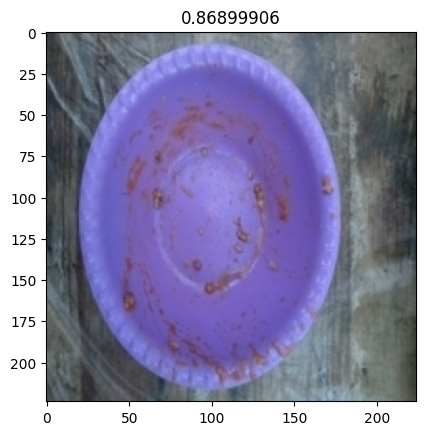

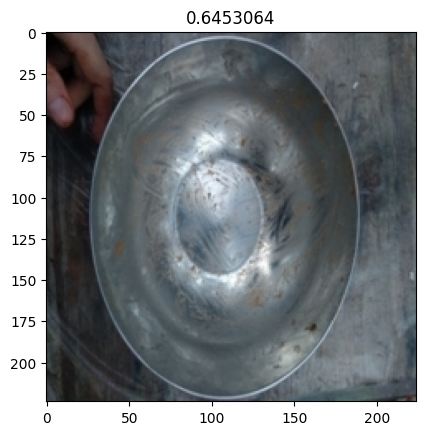

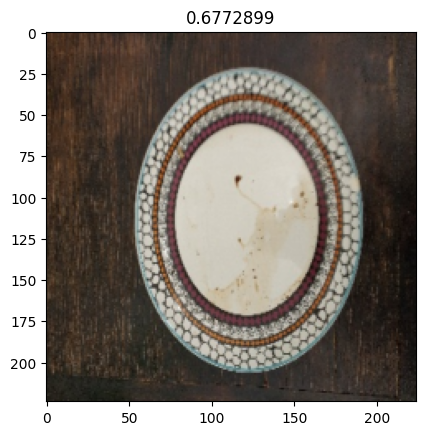

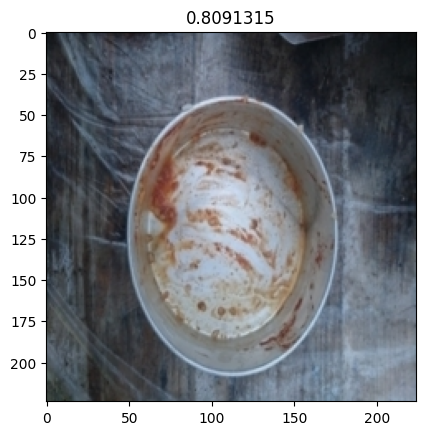

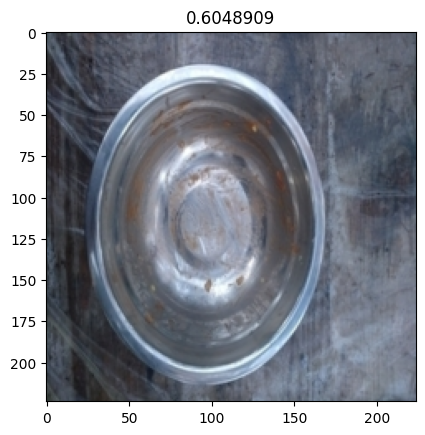

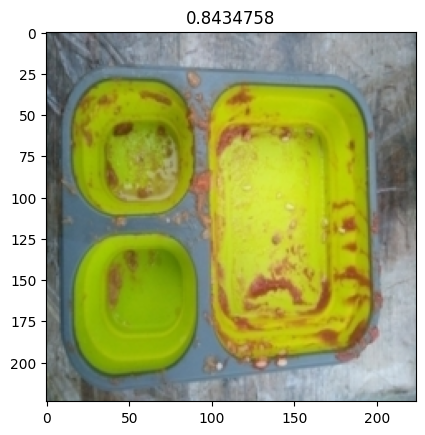

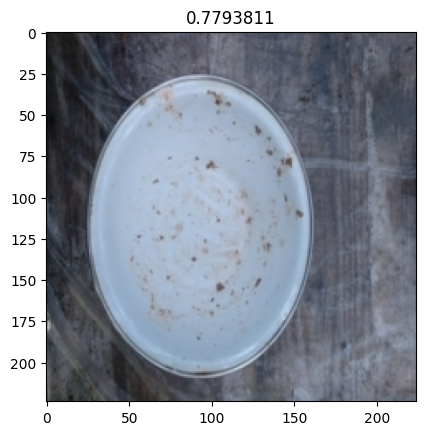

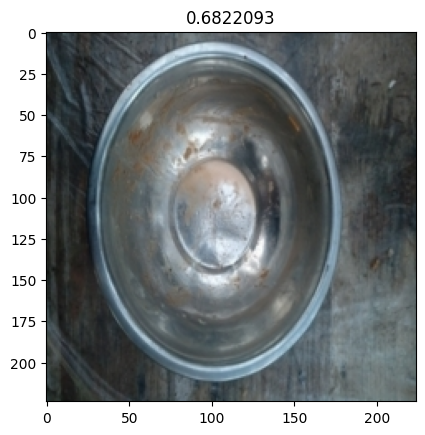

In [59]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

## Форматирование вывода

In [60]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [61]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.7 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('data/plates/test\\unknown\\', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id           
0000    dirty
0001  cleaned
0002  cleaned
0003    dirty
0004  cleaned
0005    dirty

In [62]:
submission_df.to_csv('data/submission.csv')